# FIT5226 Project Stage 2

## Group 8
- **Members:**
  - Jeeeun Kim
  - Jinxu Tao
  - Xiaolong Shen
  - Zhihan Ye

---

### 1. Introduction
In this stage, the grid world environment from Stage 1 has been extended using Deep Q-Learning (DQN) instead of a Q-table. The agent now utilizes a deep neural network to predict Q-values for state-action pairs and updates its behavior accordingly.

---

### 2. Environment Setup
**(The default grid size of 5x5 -> 4x4, goal location fixed-> random. Other than that, it is the same as in Stage 1.)**

The environment is implemented as an `n x n` grid world. The agent, item, and goal are all placed randomly within the grid. The main components of the environment are as follows:

- **Grid Size (n):** Initially set to 4x4, but can be adjusted to other sizes.
- **Agent's Position:** A randomly initialized starting position within the grid.
- **Item's Position:** A randomly placed position within the grid.
- **Goal's Position:** A randomly placed position within the grid.
  - *(The agent, item, and goal are all placed at different locations.)*
- **State Space:** Defined by the agent's position `(n x n)`, the item's position `(n x n)`, the goal's position `(n x n)`, and whether the agent is carrying the item `(1)`.
- **Action Space:** `'n', 's', 'e', 'w'` (north, south, east, west).

---

### 3. Reward Structure
The agent receives rewards and penalties based on its proximity to the item and the goal. The rewards are structured as follows:

- **Movement Penalty:** Each time the agent moves, a penalty of -0.1 is applied to discourage unnecessary movements.

#### When Carrying the Item:
- **Reaching the Goal:** The agent receives a large reward of 50 for successfully reaching the goal with the item.
- **Closer to the Goal:** The reward increases as the agent gets closer to the goal, calculated as `(10 / (distance_to_target + 1))`.

#### When Not Carrying the Item:
- **Picking Up the Item:** The agent receives a reward of 20 for picking up the item.
- **Reaching the Goal without the Item:** A penalty of -5 is applied if the agent reaches the goal without the item.
- **Closer to the Item:** The reward increases as the agent gets closer to the item, calculated as `(5 / (distance_to_item + 1))`.


---

### 4. Training Procedure

#### Before Batch Size
In this phase, the agent interacts directly with the environment and collects data through its actions.

1.Action Selection: The agent selects an action by choosing between exploration and exploitation.
2.State Transition and Reward: After performing an action, the agent transitions to a new state and receives a corresponding reward.
3.Experience Storage (Replay Buffer): Every time the agent takes a step, it stores the data consisting of the state, action, reward, next state, and whether the episode has terminated in the experience replay buffer. Learning begins only after the replay buffer has accumulated enough data equal to the batch size.

#### After Batch Size
In this phase, the agent uses the neural network to further optimize its behavior.

1.Experience Sampling: The agent randomly samples data from the replay buffer and retrieves it as a batch.
2.Q-value Calculation and Update: The Q-value for the sampled data (the predicted future rewards for each action) is calculated using the current model. The Q-value for the next state is calculated, and the Q-value is updated according to the Q-learning algorithm:
$$
Q(s, a) = r + \gamma \max_{a'} Q(s', a')
$$
The loss function (MSE) is then calculated based on this updated Q-value, and the optimizer (Adam optimizer) is used to update the weights in order to minimize the loss.

3.Target Network Update: Every fixed number of steps (500 steps), the target network is updated. The target network provides stability by not being updated too frequently. 

$$
Q(s, a) = r + \gamma \max_{a'} Q(s', a')
$$
where the value $\max_{a'} Q(s', a')$is obtained from the target network.


---

### 5. Evaluation
The trained agent is evaluated over multiple episodes using the following metrics:
Here are the results of the training with the hyperparameters set to EPSILON_DECAY_FACTOR = 0.6 and BATCH_SIZE = 50
1. **Total reward** : While there was some fluctuation initially, the overall trend showed an increase in reward as the number of episodes increased.
2. **Total Loss** : Although there were fluctuations in the loss values, a significant decrease was observed after a certain number of episodes.
2. **Steps per episode** : Although the number of steps was expected to decrease as the number of episodes increased, even with an upper limit of 100 steps, significant fluctuations were observed and no clear trend was identified.
3. **Exploration vs. Exploitation Ratio** : As the number of episodes increased, exploration decreased while exploitation increased.




In [ ]:
from IPython.display import HTML, display
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import torch
import copy
from collections import deque

In [ ]:
statespace_size=48

def prepare_torch():
  global statespace_size
  global model, model2
  global optimizer
  global loss_fn
  l1 = statespace_size
  l2 = 150
  l3 = 100
  l4 = 4

  model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)).to(torch.device("cuda"))
  model2 = copy.deepcopy(model).to(torch.device("cuda"))
  model2.load_state_dict(model.state_dict())
  loss_fn = torch.nn.MSELoss()
  learning_rate = 1e-3
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  return model2

def update_target():
  global model, model2
  model2.load_state_dict(model.state_dict())

def get_qvals(state):
    with torch.no_grad():
        state1 = torch.from_numpy(state).float().to(torch.device("cuda"))
        qvals_torch = model(state1)
        qvals = qvals_torch.cpu().detach().numpy()
    return qvals

def get_maxQ(s):
    with torch.no_grad():
        return torch.max(model2(torch.from_numpy(s).float().to(torch.device("cuda")))).item()


def train_one_step(states, actions, targets, gamma):
    # pass to this function: state1_batch, action_batch, TD_batch
    global model, model2, optimizer, loss_fn
    state1_batch = torch.from_numpy(np.array(states)).float().to(torch.device("cuda"))
    action_batch = torch.LongTensor(actions).to(torch.device("cuda"))
    target_batch = torch.FloatTensor(targets).to(torch.device("cuda"))
    current_q_values = model(state1_batch)
    current_q_values = current_q_values.gather(1, action_batch.unsqueeze(1))
    loss = loss_fn(current_q_values, target_batch.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

### Environment Set-up

The Environment class defined a n*n grid with movement of 'up', 'down', 'left', 'right' allowed. Both starting and pacel coordinates are randomly allocated in every episode. The reward are set with 100 for item pickup state, 500 for parcel delivered state and -3 for the rest of the state.

Upon every new action taken, the environment generate a new 5-dimensional state of agent's coordinate, parcel's coordinate, and pick up status. The environment also return the corresponding reward and check if the task being completed.

In [ ]:
class Environment:
    def __init__(self, size):
        # Initialize the environment with a given size
        # size: integer representing the dimensions of the grid (size x size)
        # Example: If size = 5, the grid will be 5x5
        self.dimensions = size
        # Define possible moves for the agent
        self.possible_moves = ['Up', 'Down', 'Right', 'Left']
        self.reset_environment()

    def reset_environment(self):
        # Reset the environment for a new episode
        # This method randomizes the positions of the agent, item, and destination
        # Example: In a 5x5 grid, we might have:
        # agent_location = [0, 2], item_location = [3, 4], destination = [4, 1]
        self.agent_location = self._place_randomly()
        self.item_location = self._place_randomly()
        self.destination = self._place_randomly()
        self.item_carried = False

        # Ensure agent, item, and destination are in different locations
        # This while loop keeps regenerating positions until all three are unique
        while np.array_equal(self.agent_location, self.item_location) or np.array_equal(self.agent_location, self.destination) or np.array_equal(self.item_location, self.destination):
            self.agent_location = self._place_randomly()
            self.item_location = self._place_randomly()
            self.destination = self._place_randomly()

        return self._get_state()

    def _place_randomly(self):
        # Generate a random position within the grid
        # Returns: numpy array [x, y] where 0 <= x, y < self.dimensions
        # Example: In a 5x5 grid, this might return [2, 3]
        return np.array([random.randint(0, self.dimensions - 1), random.randint(0, self.dimensions - 1)])

    def _get_state(self):
        # Encode the current state of the environment as a binary array
        # Returns: numpy array of length 48 representing the state
        # The state is encoded as follows:
        # - First 16 bits: agent position (one-hot encoded)
        # - Next 16 bits: item position (one-hot encoded, or all 0 if item is carried)
        # - Next 15 bits: destination position (one-hot encoded)
        # - Last bit: whether the item is carried (1) or not (0)
        state = np.zeros(48, dtype=int)

        # Calculate positions in the flattened grid
        # Example: In a 4x4 grid, position [1, 2] would be 1*4 + 2 = 6
        agent_pos = int(self.agent_location[0] * self.dimensions + self.agent_location[1])
        item_pos = int(self.item_location[0] * self.dimensions + self.item_location[1])
        dest_pos = int(self.destination[0] * self.dimensions + self.destination[1])

        # Set corresponding bits in the state array
        state[agent_pos] = 1
        state[item_pos + 16] = 1 if not self.item_carried else 0
        state[dest_pos + 32] = 1
        if self.item_carried:
            state[48] = 1

        return state

    def execute_move(self, move):
        # Execute a move and update the agent's position
        # move: string, one of 'Up', 'Down', 'Right', 'Left'
        # Returns: new agent location after the move
        # Example: If agent is at [2, 2] and move is 'Up', new position is [1, 2]
        move_effects = {
            'Up': np.array([-1, 0]),
            'Down': np.array([1, 0]),
            'Right': np.array([0, 1]),
            'Left': np.array([0, -1])
        }

        if move in move_effects:
            new_location = self.agent_location + move_effects[move]
            # Check if the new location is within the grid boundaries
            if np.all((new_location >= 0) & (new_location < self.dimensions)):
                self.agent_location = new_location

        return self.agent_location

    def update_item_status(self):
        # Update the status of the item (picked up or not)
        # If the agent is at the item's location and hasn't picked it up yet, pick it up
        # Example: If agent_location = [2, 3] and item_location = [2, 3], item_carried becomes True
        if np.array_equal(self.agent_location, self.item_location) and not self.item_carried:
            self.item_carried = True

    def determine_reward(self):
        # Calculate the reward based on the current state
        # Returns: integer reward value
        # Reward structure:
        # - Picking up the item: +100
        # - Reaching item location while carrying the item: -50 (discourages loitering)
        # - Reaching destination with item: +500 (task completion)
        # - Any other move: -3 (encourages efficiency)
        if np.array_equal(self.agent_location, self.item_location) and not self.item_carried:
            self.item_carried = True
            return 100
        elif np.array_equal(self.agent_location, self.item_location) and self.item_carried:
            return -50
        elif np.array_equal(self.agent_location, self.destination) and self.item_carried:
            return 500
        else:
            return -3

    def take_action(self, move):
        # Execute a full action cycle: move, update state, calculate reward
        # move: string, one of 'Up', 'Down', 'Right', 'Left'
        # Returns: tuple (new_state, reward, task_complete, info)
        # Example:
        # - Initial state: agent at [1, 1], item at [1, 2], not carried
        # - Action: 'Right'
        # - Result: agent moves to [1, 2], picks up item, gets reward 100
        #           new state reflects item being carried, task not complete yet
        self.execute_move(move)
        reward = self.determine_reward()
        self.update_item_status()
        task_complete = np.array_equal(self.agent_location, self.destination) and self.item_carried
        state = self._get_state()
        return state, reward, task_complete, {}

    def manhattan_distance(self, point1, point2):
        # Calculate the Manhattan distance between two points
        # point1, point2: numpy arrays [x, y]
        # Returns: integer distance
        # Example: Distance between [1, 1] and [4, 3] is |4-1| + |3-1| = 5
        return abs(point1[0] - point2[0]) + abs(point1[1] - point2[1])

    def cal_best_performance(self):
        # Calculate the optimal path length
        # Returns: integer, minimum number of steps to complete the task
        # Example: If agent is at [0, 0], item at [2, 2], and destination at [4, 4]
        # Best performance would be: 4 (to item) + 4 (to destination) = 8 steps
        to_item = self.manhattan_distance(self.agent_location, self.item_location)
        to_goal = self.manhattan_distance(self.item_location, self.destination)
        return to_item + to_goal

    def cal_best_reward(self):
        # Calculate the maximum possible reward for the current configuration
        # Returns: integer, best possible reward
        # Example: If best performance is 8 steps
        # Best reward = 606 - (8 * 3) = 582
        # 606 is the sum of rewards for pickup (100) and delivery (500)
        # Each step costs 3, so we subtract (best_step * 3)
        best_step = self.cal_best_performance()
        return 606 - best_step * 3

### Q-learning Agent class

- Using DQN neural network model to train and solve the path selection problem of agents, mainly by minimizing the loss of predicted target Q value to update parameters, and using MSEloss to calculate the loss and backpropagation to perform gradient descent calculation, making the predicted Q value closer to the TD target value.
In the early stage of training, the next action is randomly selected and the current state is recorded, and the data is stored in a buffer. After storing 400 steps of information, the previously stored information is randomly selected to update the Q-value network.
The buffer follows the first in, first out principle. When the upper limit is reached, the first state to enter will be cleared and the loop will be repeated until the training is completed. The approximate structure is shown in the figure:

  -
   [](https://s2.loli.net/2024/09/15/x8BJhGzLqU5QeWp.png)
  <img src = "https://s2.loli.net/2024/09/15/x8BJhGzLqU5QeWp.png" width = "50%" height = "50%"/>

In [ ]:
class DeepQLearningAgent_A2:
    def __init__(self, possible_moves, learning_rate, future_reward_discount, initial_exploration_rate, min_exploration_rate, exploration_rate_decay, replay_buffer_size, batch_size, copy_frequency):
        # Initialize the Deep Q-learning agent with learning parameters

        self.possible_moves = possible_moves  # List of actions the agent can take
        # ['Up', 'Down', 'Left', 'Right']

        self.learning_rate = learning_rate  # Learning rate for the neural network
        # determines how much to adjust the model in response to the estimated error each time the model weights are updated

        self.future_discount = future_reward_discount  # Discount factor for future rewards
        # a high value (close to 1) means the agent cares more about long-term reward

        self.exploration_rate = initial_exploration_rate  # Initial exploration rate for epsilon-greedy policy
        # start with 100% random actions to encourage exploration

        self.min_exploration_rate = min_exploration_rate  # Minimum exploration rate after decay
        # ensure at least 1% of actions are random even after long training

        self.exploration_decay = exploration_rate_decay  # Factor for exploration rate decay
        #multiply exploration rate by this value after each episode

        self.replay_buffer = deque(maxlen=replay_buffer_size)  # Experience replay buffer
        # deque with maxlen=10000 to store the last 10000 experiences

        self.batch_size = batch_size  # Size of minibatch for training
        # train on 200 random samples from the replay buffer at each step

        self.copy_frequency = copy_frequency  # Frequency of copying main network to target network
        # copy weights every 500 steps to stabilize training

        self.step_count = 0  # Counter for total steps taken

        # Dictionaries to track agent's performance during training and testing
        self.performance_history = {'rewards': [], 'best_rewards': [], 'steps': [], 'best_steps': [], 'exploration_rate': []}
        self.test_history = {'rewards': [], 'best_rewards': [], 'steps': [], 'best_steps': []}

        # Initialize neural network models, optimizer, and loss function
        global model, model2, optimizer, loss_fn
        model2 = prepare_torch()  # This initializes model, model2, optimizer, and loss_fn

    def store_transition(self, state, action, reward, next_state, done):
        # Store a transition in the replay buffer
        #
        # Parameters:
        # - state: Current state (e.g., [0,0,1,0,0,0,1,0] representing agent and item positions)
        # - action: Action taken (e.g., 'Up')
        # - reward: Reward received (e.g., -3 for a normal move, 100 for picking up the item)
        # - next_state: Resulting state after taking the action
        # - done: Boolean indicating if the episode has ended
        #
        # self.store_transition([0,0,1,0,0,0,1,0], 'Up', -3, [0,1,0,0,0,0,1,0], False)
        self.replay_buffer.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        # Choose an action using epsilon-greedy policy during training
        if random.random() < self.exploration_rate:
            return random.choice(self.possible_moves)  # Explore: choose random action
        else:
            q_values = get_qvals(state)  # Exploit: get Q-values from the neural network
            return self.possible_moves[np.argmax(q_values)]  # Choose action with highest Q-value

        # If exploration_rate is 0.1, there's a 10% chance of choosing a random action
        # If not exploring, and Q-values are [0.1, 0.2, 0.15, 0.05] for ['Up', 'Down', 'Left', 'Right']
        # The method will return 'Down' as it has the highest Q-value

    def choose_action_test(self, state):
        # Choose an action for testing (no exploration)
        with torch.no_grad():
            q_values = get_qvals(state)
        return self.possible_moves[np.argmax(q_values)]

        # If Q-values are [0.1, 0.2, 0.15, 0.05] for ['Up', 'Down', 'Left', 'Right']
        # The method will always return 'Down' as it has the highest Q-value

    def sample_minibatch(self, batch_size):
        # Sample a minibatch of transitions from the replay buffer
        minibatch = random.sample(self.replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        return np.array(states), actions, np.array(rewards), np.array(next_states), np.array(dones)

        # If batch_size is 2, it might return:
        # states: np.array([[0,0,1,0,0,0,1,0], [0,1,0,0,0,0,1,0]])
        # actions: ('Up', 'Down')
        # rewards: np.array([-3, 100])
        # next_states: np.array([[0,1,0,0,0,0,1,0], [0,0,0,1,0,0,1,0]])
        # dones: np.array([False, False])

    def update_q_network(self, states, actions, td_targets):
        # Update the Q-network using a batch of experiences
        #
        # Parameters:
        # - states: Batch of states
        # - actions: Batch of actions taken
        # - td_targets: Batch of TD targets (Q-learning targets)
        action_indices = [self.possible_moves.index(a) for a in actions]
        loss = train_one_step(states, action_indices, td_targets, self.future_discount)
        return loss

        # If states = [[0,0,1,0,0,0,1,0], [0,1,0,0,0,0,1,0]]
        # actions = ['Up', 'Down']
        # td_targets = [97, 95]  (calculated from reward + future_discount * max future Q-value)
        # This will update the Q-network to better predict these TD targets for the given states and actions

    def update_target_network(self):
        # Update the target network by copying weights from the main network
        update_target()

        # This stabilizes training by providing a stable target for Q-value updates
        # It's typically called every `copy_frequency` steps

    def adjust_learning_parameters(self):
        # Adjust the exploration rate (decay epsilon)
        self.exploration_rate = max(self.min_exploration_rate, self.exploration_rate * self.exploration_decay)

        # If current exploration_rate is 0.5 and exploration_decay is 0.995:
        # New exploration_rate = max(0.01, 0.5 * 0.995) = 0.4975
        # This gradually reduces random actions as the agent learns

    def record_performance(self, reward, best_reward, steps, best_steps):
        # Record performance metrics for the current training episode
        self.performance_history['rewards'].append(reward)
        self.performance_history['best_rewards'].append(best_reward)
        self.performance_history['steps'].append(steps)
        self.performance_history['best_steps'].append(best_steps)
        self.performance_history['exploration_rate'].append(self.exploration_rate)

        # After an episode where the agent got a total reward of 450 in 20 steps,
        # and the best possible reward was 500 in 15 steps:
        # record_performance(450, 500, 20, 15)

    def record_performance_test(self, reward, best_reward, steps, best_steps):
        # Record performance metrics for the current testing episode
        self.test_history['rewards'].append(reward)
        self.test_history['best_rewards'].append(best_reward)
        self.test_history['steps'].append(steps)
        self.test_history['best_steps'].append(best_steps)

        # Similar to record_performance, but used during testing phases
        # This allows comparison between training and testing performance

    def get_q_values(self, state):
        # Get Q-values for all actions in the given state
        return get_qvals(state)

        # For state [0,0,1,0,0,0,1,0], it might return:
        # [0.1, 0.2, 0.15, 0.05] for actions ['Up', 'Down', 'Left', 'Right']

    def get_max_q_value(self, state):
        # Get the maximum Q-value for the given state
        return get_maxQ(state)

        # If get_q_values(state) returns [0.1, 0.2, 0.15, 0.05]
        # This method will return 0.2

In [ ]:
#A2 parameters

grid_size = 4
learning_rate = 0.997
future_reward_discount = 0.9
initial_exploration_rate = 1.0
min_exploration_rate = 0.1
exploration_rate_decay = 0.997
num_training_episodes = 10000
max_step_limit = 100
replay_buffer_size = 1000
batch_size = 200
copy_frequency = 500

### Main Training phase
Main training phases for updating q-values for the q-table upon each steps being exacuted. Metrics including steps taken for termination and cumulative rewards are stored for further performance evaluation.  

In [ ]:
def train_intelligent_agent_A2(environment, agent, num_training_episodes, max_step_limit, print_interval=1):
    total_steps = 0
    episode_train_count = 0
    for episode in range(num_training_episodes):
        agent.adjust_learning_parameters()
        state = environment.reset_environment()
        best_steps = environment.cal_best_performance()
        episode_best_reward = environment.cal_best_reward()
        episode_reward = 0
        episode_loss = 0

        for step in range(max_step_limit):
            # Sample phase
            action = agent.choose_action(state)
            next_state, reward, done, _ = environment.take_action(action)

            # Store transition in the experience replay buffer
            agent.store_transition(state, action, reward, next_state, done)

            total_steps += 1
            episode_reward += reward

            # Learn phase when step is greater than 200 which mean each step will train ones
            if total_steps > agent.batch_size:
                states, actions, rewards, next_states, dones = agent.sample_minibatch(agent.batch_size)

                td_targets = []
                for i in range(agent.batch_size):
                    best_future_value = get_maxQ(next_states[i])
                    td_target = rewards[i] + agent.future_discount * best_future_value * (1 - dones[i])
                    td_targets.append(td_target)

                action_idxs = [environment.possible_moves.index(j) for j in actions]

                loss = train_one_step(states, action_idxs, td_targets, agent.future_discount)

                episode_loss += loss
                episode_train_count += 1

            # Update target network every 500 steps
            if total_steps % agent.copy_frequency == 0:
                update_target()

            if done:
                break

            state = next_state

        # End of episode
        agent.record_performance(episode_reward, episode_best_reward, step + 1, best_steps)
        # print summary of the tranning
        if episode % print_interval == 0:
            print(f"Episode {episode + 1}: Reward = {episode_reward:.2f}, "
                  f"Steps = {step + 1}, Loss = {episode_loss / (step + 1):.4f}, "
                  f"Exploration Rate = {agent.exploration_rate:.4f}, "
                  f"Train Count = {episode_train_count}")

    return agent

### Training Execution

In [ ]:
env = Environment(size = grid_size)
# used pervious parameter to train the agent
intelligent_agent = DeepQLearningAgent_A2(
    possible_moves         = env.possible_moves,
    learning_rate  = learning_rate,
    future_reward_discount = future_reward_discount,
    initial_exploration_rate = initial_exploration_rate,
    min_exploration_rate   = min_exploration_rate,
    exploration_rate_decay = exploration_rate_decay,
    replay_buffer_size = replay_buffer_size,
    batch_size = batch_size,
    copy_frequency = copy_frequency
)
trained_agent = train_intelligent_agent_A2(env, intelligent_agent, num_training_episodes, max_step_limit = max_step_limit)


Episode 1: Reward = 263.00, Steps = 36, Loss = 0.0000, Exploration Rate = 0.9970, Train Count = 0
Episode 2: Reward = 273.00, Steps = 64, Loss = 0.0000, Exploration Rate = 0.9940, Train Count = 0
Episode 3: Reward = -761.00, Steps = 100, Loss = 0.0000, Exploration Rate = 0.9910, Train Count = 0
Episode 4: Reward = -385.00, Steps = 100, Loss = 2393.3536, Exploration Rate = 0.9881, Train Count = 100
Episode 5: Reward = 399.00, Steps = 69, Loss = 1555.2474, Exploration Rate = 0.9851, Train Count = 169
Episode 6: Reward = 484.00, Steps = 25, Loss = 1805.0140, Exploration Rate = 0.9821, Train Count = 194
Episode 7: Reward = -300.00, Steps = 100, Loss = 1787.3928, Exploration Rate = 0.9792, Train Count = 294
Episode 8: Reward = -300.00, Steps = 100, Loss = 1314.8373, Exploration Rate = 0.9763, Train Count = 394
Episode 9: Reward = 75.00, Steps = 83, Loss = 1085.3635, Exploration Rate = 0.9733, Train Count = 477
Episode 10: Reward = 443.00, Steps = 23, Loss = 1044.2874, Exploration Rate = 0.9

### Metrics evaluation and Graph Plotting

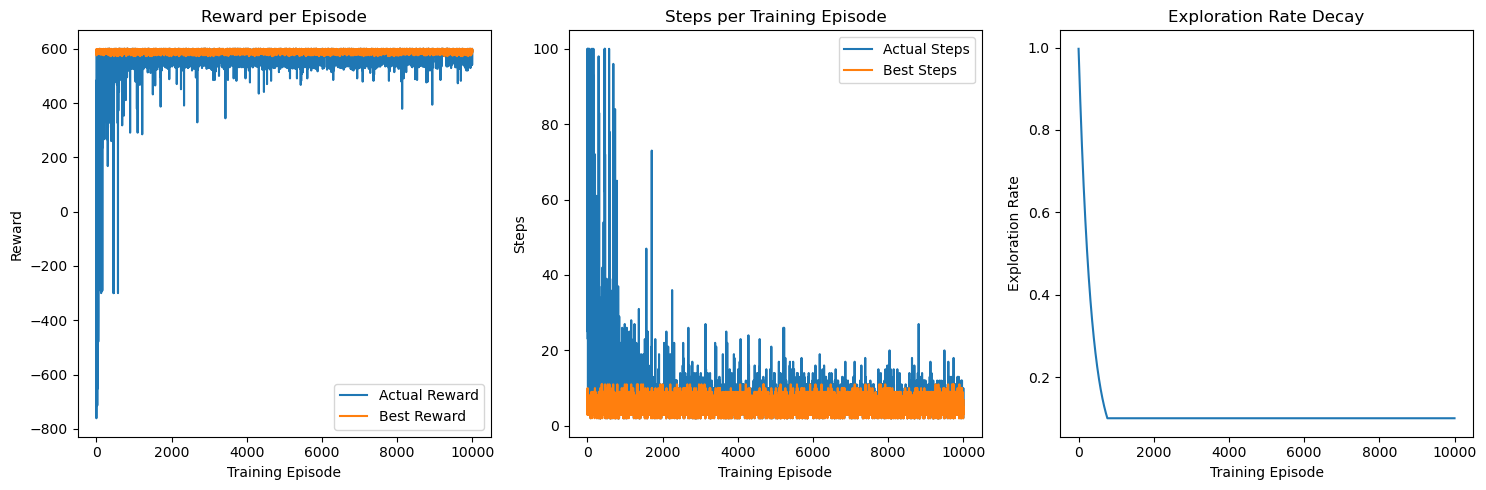

In [ ]:
import matplotlib.pyplot as plt

def plot_training_results(agent):
    rewards = agent.performance_history['rewards']
    best_rewards = agent.performance_history['best_rewards']
    steps = agent.performance_history['steps']
    best_steps = agent.performance_history['best_steps']
    exploration_rates = agent.performance_history['exploration_rate']
    episodes = range(len(rewards))

    _, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot average reward
    axs[0].plot(episodes, rewards, label='Actual Reward')
    axs[0].plot(episodes, best_rewards, label='Best Reward')
    axs[0].set_title('Reward per Episode')
    axs[0].set_xlabel('Training Episode')
    axs[0].set_ylabel('Reward')
    axs[0].legend()


    # Plot steps per episode
    axs[1].plot(episodes, steps, label='Actual Steps')
    axs[1].plot(episodes, best_steps, label='Best Steps')
    axs[1].set_title('Steps per Training Episode')
    axs[1].set_xlabel('Training Episode')
    axs[1].set_ylabel('Steps')
    axs[1].legend()

    # Plot exploration rate decay
    axs[2].plot(episodes, exploration_rates)
    axs[2].set_title('Exploration Rate Decay')
    axs[2].set_xlabel('Training Episode')
    axs[2].set_ylabel('Exploration Rate')

    plt.tight_layout()
    plt.show()


plot_training_results(trained_agent)

In [ ]:
def test_intelligent_agent_A2(environment, agent, num_test_episodes, max_step_limit):
    agent.test_history = {'rewards': [], 'best_rewards': [], 'steps': [], 'best_steps': []}
    for episode in range(num_test_episodes):
        state = environment.reset_environment()
        best_steps = environment.cal_best_performance()
        episode_best_reward = environment.cal_best_reward()
        episode_reward = 0
        steps_taken = 0

        for _ in range(max_step_limit):
            action = agent.choose_action_test(state)
            next_state, reward, done, _ = environment.take_action(action)
            steps_taken += 1
            state = next_state
            episode_reward += reward

            if done:
                break

        agent.record_performance_test(episode_reward, episode_best_reward, steps_taken, best_steps)

        print(f"Episode {episode + 1}: Reward = {episode_reward}, Best Rewards = {episode_best_reward}, Steps = {steps_taken}, Best Steps = {best_steps}")

    return agent

Episode 1: Reward = 591, Best Rewards = 591, Steps = 5, Best Steps = 5
Episode 2: Reward = 591, Best Rewards = 591, Steps = 5, Best Steps = 5
Episode 3: Reward = 594, Best Rewards = 594, Steps = 4, Best Steps = 4
Episode 4: Reward = 591, Best Rewards = 591, Steps = 5, Best Steps = 5
Episode 5: Reward = 582, Best Rewards = 582, Steps = 8, Best Steps = 8
Episode 6: Reward = 588, Best Rewards = 588, Steps = 6, Best Steps = 6
Episode 7: Reward = 591, Best Rewards = 591, Steps = 5, Best Steps = 5
Episode 8: Reward = 594, Best Rewards = 594, Steps = 4, Best Steps = 4
Episode 9: Reward = 588, Best Rewards = 588, Steps = 6, Best Steps = 6
Episode 10: Reward = 594, Best Rewards = 594, Steps = 4, Best Steps = 4
Episode 11: Reward = 597, Best Rewards = 597, Steps = 3, Best Steps = 3
Episode 12: Reward = 594, Best Rewards = 594, Steps = 4, Best Steps = 4
Episode 13: Reward = 591, Best Rewards = 591, Steps = 5, Best Steps = 5
Episode 14: Reward = 588, Best Rewards = 588, Steps = 6, Best Steps = 6
E

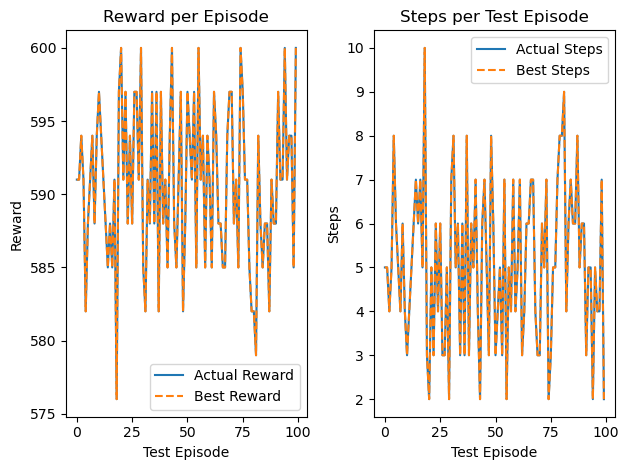

In [ ]:
def plot_test_results(agent):
    rewards = agent.test_history['rewards']
    best_rewards = agent.test_history['best_rewards']
    steps = agent.test_history['steps']
    best_steps = agent.test_history['best_steps']
    episodes = range(len(rewards))

    _, axs = plt.subplots(1, 2)

    # Plot average reward
    axs[0].plot(episodes, rewards, label='Actual Reward')
    axs[0].plot(episodes, best_rewards, label='Best Reward', linestyle='--')
    axs[0].set_title('Reward per Episode')
    axs[0].set_xlabel('Test Episode')
    axs[0].set_ylabel('Reward')
    axs[0].legend()

    # Plot steps per episode
    axs[1].plot(episodes, steps, label='Actual Steps')
    axs[1].plot(episodes, best_steps, label='Best Steps', linestyle='--')
    axs[1].set_title('Steps per Test Episode')
    axs[1].set_xlabel('Test Episode')
    axs[1].set_ylabel('Steps')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

num_test_episods = 100
plot_test_results(test_intelligent_agent_A2(env, trained_agent, num_test_episods, max_step_limit))

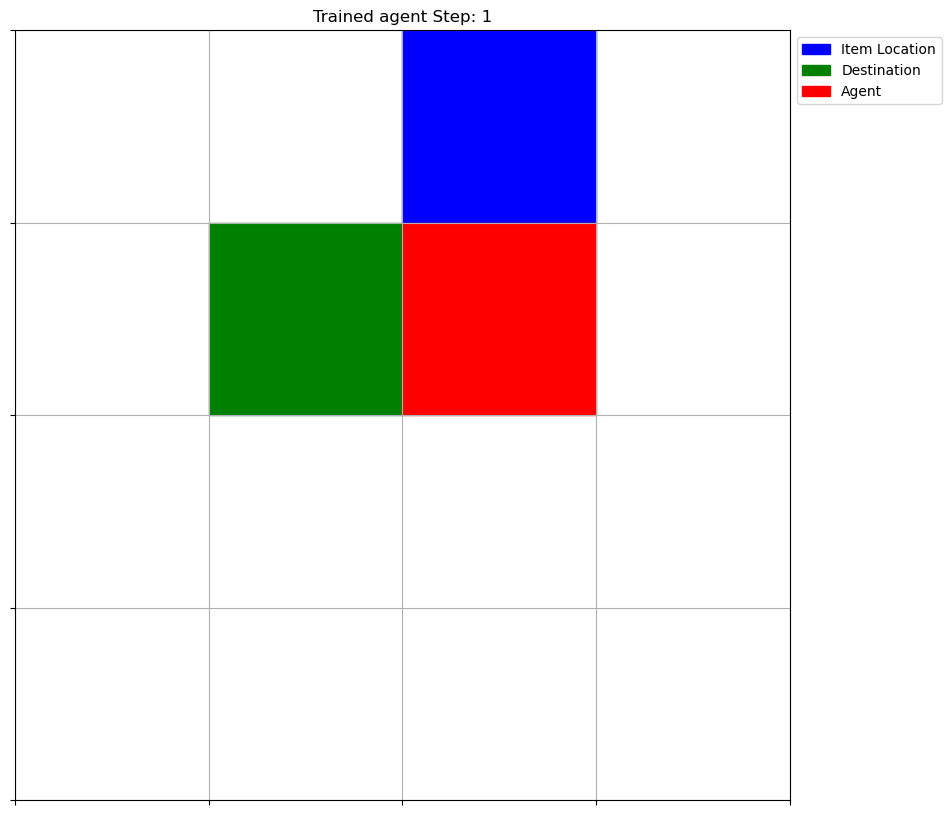

In [ ]:
def create_result_animation(env, intelligent_agent):
    fig, ax = plt.subplots(figsize=(10,10))


    #reset environment(location of agent,item and drop off point),initial path, item carry status,and task
    state = env.reset_environment()
    path = [env.agent_location]
    item_status = [env.item_carried]
    task_complete = False

    #train agent until complete which is let agent pick up item and get to the drop off point then one task is completed
    while not task_complete:
        action = intelligent_agent.choose_action(state)
        state, reward, task_complete, _ = env.take_action(action)
        path.append(env.agent_location)
        item_status.append(env.item_carried)

    def animate(frame):
      # clear the graph
        ax.clear()
        ax.set_xlim(0, env.dimensions)
        ax.set_ylim(0, env.dimensions)
        ax.set_xticks(range(env.dimensions + 1))
        ax.set_yticks(range(env.dimensions + 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(True)

        # Draw item location when item is not pick up
        if not item_status[frame]:
            ax.add_patch(patches.Rectangle((env.item_location[1], env.dimensions - env.item_location[0] - 1),1, 1, fill=True, color="blue", label="Item Location"))

        # Draw destination
        ax.add_patch(patches.Rectangle((env.destination[1], env.dimensions - env.destination[0] - 1),1, 1, fill=True, color="green", label="Destination"))

        # Draw agent
        current_pos = path[frame]
        agent_color = "red" if not item_status[frame] else "purple"
        agent_label = "Agent" if frame == 0 else None  # Only label the agent in the first frame
        ax.add_patch(patches.Rectangle((current_pos[1], env.dimensions - current_pos[0] - 1), 1, 1, fill=True, color=agent_color, label=agent_label))

        # Draw path
        path_x = [pos[1] + 0.5 for pos in path[:frame+1]]
        path_y = [env.dimensions - pos[0] - 0.5 for pos in path[:frame+1]]
        ax.plot(path_x, path_y, color='orange', linewidth=2, alpha=0.5)

        ax.set_title(f"{'Trained agent'} Step: {frame + 1}")

        if frame == 0:
          ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

        return ax.patches + ax.lines

    anim = animation.FuncAnimation(fig, animate, frames=len(path), interval=500, blit=False, repeat=True)
    return anim

result_animation = create_result_animation(env, trained_agent)
display(HTML(result_animation.to_jshtml()))

In [ ]:
# fmpl.rcParams['animation.embed_limit'] = 100

class untrainedAgent:
    def __init__(self, possible_moves):
        self.possible_moves = possible_moves

    def choose_action(self, state):
        return random.choice(self.possible_moves)

def create_untrained_movement_animation(env, agent, is_trained=True):
    fig, ax = plt.subplots(figsize=(10,10))

    state = env.reset_environment()
    path = [env.agent_location]
    item_status = [env.item_carried]
    task_complete = False

    while not task_complete and len(path) < 100:
        action = agent.choose_action(state)
        state, reward, task_complete, _ = env.take_action(action)
        path.append(env.agent_location)
        item_status.append(env.item_carried)

    def animate(frame):
      # clear the graph
        ax.clear()
        ax.set_xlim(0, env.dimensions)
        ax.set_ylim(0, env.dimensions)
        ax.set_xticks(range(env.dimensions + 1))
        ax.set_yticks(range(env.dimensions + 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(True)

        if not item_status[frame]:
          # Draw item location when item is not pick up
          ax.add_patch(patches.Rectangle((env.item_location[1], env.dimensions - env.item_location[0] - 1),1, 1, fill=True, color="blue", label="Item Location"))

          # Draw destination
          ax.add_patch(patches.Rectangle((env.destination[1], env.dimensions - env.destination[0] - 1),1, 1, fill=True, color="green", label="Destination"))

          #draw agent
          current_pos = path[frame]
          agent_color = "red" if not item_status[frame] else "purple"
          agent_label = "Agent" if frame == 0 else None
          ax.add_patch(patches.Rectangle((current_pos[1], env.dimensions - current_pos[0] - 1),1, 1, fill=True, color=agent_color, label=agent_label))

          # Draw path
          path_x = [pos[1] + 0.5 for pos in path[:frame+1]]
          path_y = [env.dimensions - pos[0] - 0.5 for pos in path[:frame+1]]
          ax.plot(path_x, path_y, color='orange', linewidth=2, alpha=0.5)

          ax.set_title(f"{'Trained' if is_trained else 'Untrained'} Agent - Step: {frame + 1}")

        if frame == 0:
          ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

        return ax.patches + ax.lines

    anim = animation.FuncAnimation(fig, animate, frames=len(path), interval=500, blit=False, repeat=False)
    return anim


new_env = Environment(size= grid_size)


untrained_agent = untrainedAgent(possible_moves=new_env.possible_moves)


untrained_animation = create_untrained_movement_animation(new_env, untrained_agent, is_trained=False)


display(HTML(untrained_animation.to_jshtml()))


NameError: name 'Environment' is not defined

### Conslusion and Observation

Observation:

  - **Circumstance 1** (Figure 1): In the stage 1, we used the average Manhattan distance line (red line in Figure 1) to represent the default shortest distance. However, since the initial coordinate points in the map generated during each training session are random, the single value of the average Manhattan distance cannot be generalized, and it cannot well represent whether each training session has reached the optimal step count standard. So we choose to calculate and store the Manhattan distance of each training session as the shortest distance to verify whether it meets the expected standard (Figure 2)

 - ***Figure 1***:

 - ![Figure1 _2_.png](https://s2.loli.net/2024/09/14/BFAlmSIqMHNKbcn.png)

 - **Circumstance 2** (Figure 2):
 ![348b14c4b5519c1321bb580b2411c0c.png](https://s2.loli.net/2024/09/15/2N3SKVvx71Rhi8Y.png)

  - **Circumstance 2** After 10000 rounds of training, use the trained agent to test 100 randomly generated maps. The method for generating starting, picking, and ending points within the test map is consistent with the training method. In the comparison after testing(Figure 3), it was founded that the actual reward obtained from 100 test values was exactly the same as the best reward value calculated through calculation and the best number of steps calculated by Manhattan distance function. This indicates that training with DQN was very successful, and both the steps and rewards were consistent with the best.

- Figure 3:

    ![0857424fe118a4288319001acddcdcf.png](https://s2.loli.net/2024/09/15/h5JeluTEfo3xBgd.png)

### Conclusion:

After 10000 rounds of training, the performance of finish trained DQN network have a great performance during the testing process indeed proves its ability to select optimal paths, which can help agents choose the shortest path and achieve the expected path selection of the model in advance.